# Speaker Diarization Using LSTM and GANMM
Here we will be making embddings for the short audio segments, using there MFCC features collected through 'Data Preprocessing.ipynb'. We have trained a LSTM nural network to get embedding vectors of dimention (256,). These embeddings will further be clustered using spectral clustering and GANMM, the former being the state of the art mthord and the later being our varient to the speaker diarization problem. Finally, we will be testing and comparing both models on imbalanced data and evaluate them on Diarization Error Rates(DERs), F1 scores and Confusion matrix.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Advanced\ ML\ project/Data_MFCC_features

/content/drive/MyDrive/Advanced ML project/Data_MFCC_features


In [3]:
ls

Augmented_Data/               mel_save_test_IB4011.npy
mel_labels_test_custom_1.npy  mel_save_test_IS1000c.npy
mel_labels_test_custom_2.npy  mel_save_test_TS3010c.npy
mel_labels_test_IB4011.npy    mel_save_train.npy
mel_labels_test_IS1000c.npy   timestamps_save_custom_1.npy
mel_labels_test_TS3010c.npy   timestamps_save_custom_2.npy
mel_labels_train.npy          timestamps_save_IB4011.npy
mel_save_test_custom_1.npy    timestamps_save_IS1000c.npy
mel_save_test_custom_2.npy    timestamps_save_TS3010c.npy


## Loading libraries and importing packages




In [4]:
!pip3 install spectralcluster
!pip install tensorflow_addons 
!pip install pyannote.core
!pip install pyannote.metrics

     |████████████████████████████████| 686kB 13.4MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 133kB 20.0MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0


In [77]:
%pylab inline
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from pyannote.core import Annotation, Segment
from keras.utils.vis_utils import plot_model
from spectralcluster import SpectralClusterer
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sn

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Annotation']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Loading data

In [6]:
X = np.load('./mel_save_train.npy') # mfcc features of dimension 20
y = np.load('./mel_labels_train.npy') # true speaker labels of those feature vector

In [7]:
print(X.shape)
print(y.shape)

(16040, 44, 20)
(16040,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
def _map_sound(img, label):
    return (img, label)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset= train_dataset.batch(32)
train_dataset = train_dataset.map(_map_sound)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset= test_dataset.batch(32)
test_dataset = test_dataset.map(_map_sound)




## Model Architecture and Training


In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(768,  input_shape=(44,20), return_sequences=True))  # returns a sequence of vectors of dimension 768
model.add(layers.LSTM(768,return_sequences=True))  # returns a sequence of vectors of dimension 768
model.add(layers.LSTM(768))  # return a single vector of dimension 768
model.add(layers.Dense(256, activation='tanh')) 
model.add(layers.Dropout(0.01))
model.add(layers.Dense(256, activation=None))
model.add(layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))) # normalization for d vector embedding


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 44, 768)           2423808   
_________________________________________________________________
lstm_4 (LSTM)                (None, 44, 768)           4721664   
_________________________________________________________________
lstm_5 (LSTM)                (None, 768)               4721664   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               196864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
lambda_1 (Lambda)            (None, 256)              

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(         # Use Stochastic gradient descent for optimizing the model
        learning_rate=0.003,momentum=0.05),
    loss=tfa.losses.TripletHardLoss())         # Use Triplet Hard Loss for making same speaker embeddings similar

In [ ]:
history = model.fit(train_dataset,epochs=90, validation_data=test_dataset)   # Training

Epoch 1/90
401/401 [==============================] - 21s 43ms/step - loss: 0.5478 - val_loss: 0.4565
Epoch 2/90
401/401 [==============================] - 16s 40ms/step - loss: 0.4254 - val_loss: 0.4155
Epoch 3/90
401/401 [==============================] - 16s 40ms/step - loss: 0.3939 - val_loss: 0.4172
Epoch 4/90
401/401 [==============================] - 16s 40ms/step - loss: 0.3803 - val_loss: 0.4097
Epoch 5/90
401/401 [==============================] - 16s 40ms/step - loss: 0.3736 - val_loss: 0.4047
Epoch 6/90
401/401 [==============================] - 16s 41ms/step - loss: 0.3681 - val_loss: 0.3955
Epoch 7/90
401/401 [==============================] - 16s 40ms/step - loss: 0.3659 - val_loss: 0.4417
Epoch 8/90
401/401 [==============================] - 16s 40ms/step - loss: 0.3646 - val_loss: 0.4068
Epoch 9/90
401/401 [==============================] - 16s 40ms/step - loss: 0.3598 - val_loss: 0.3985
Epoch 10/90
401/401 [==============================] - 16s 40ms/step - loss: 0.360

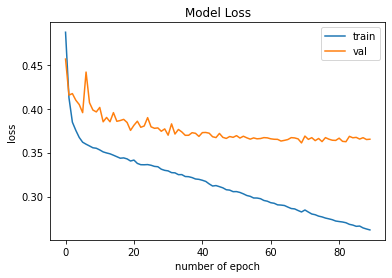

In [ ]:
plt.plot(history.history['loss'])              # Plotting the train and validation loss accross epochs to analyze performance change
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('number of epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model.save('../saved models/model_4.h5')

In [53]:
model = tf.keras.models.load_model('../saved models/M_0.003_0.03_0.2658_0.3603.h5')  # Loading previously saved model

In [54]:
model.evaluate(X_train,y_train)
model.evaluate(X_test,y_test)

101/101 [==============================] - 2s 12ms/step - loss: 0.3706


0.37056276202201843

In [11]:
train_embeddings = model.predict(X_train)
np.save('../Embeddings/train_embeddings',train_embeddings)
np.save('../Embeddings/train_labels',y_train)

## Testing the model on AMI data corpus 

Here we take some unseen test audio files from the AMI Corpus, and evaluate the performance of the model using Spectral Clustering and GANMM(GAN mixture model). We shall compare the models using the evaluation metrics of DER, F1 score and confusion matrix. The testing will be done on both balanced and imbalanced data.



In [12]:
def load_test_file(x_loc, y_loc, time_stamp_loc):
    X_test_us = np.load(x_loc) # mfcc features of dimension 20
    y_test_us = np.load(y_loc) # true speaker labels of those feature vector
    time_stamp_us = np.load(time_stamp_loc) # true speaker labels of those feature vector
    return (X_test_us, y_test_us, time_stamp_us)

In [96]:
def plot_scatter_embedding(embedding_2d, y_label, graph_title):   # For plotting 2D graph of embeddings
    a=[]
    b=[]
    colors = ['red','green','blue','pink','brown','black']
    color_list = []
    for i in range(embedding_2d.shape[0]):
      a.append(embedding_2d[i][0])
      color_list.append(colors[y_label[i]])
    for i in range(embedding_2d.shape[0]):
      b.append(embedding_2d[i][1])
    plt.scatter(a,b,color = color_list)
    plt.title(graph_title)
    plt.show()


def make_spectral_clusters(test_d_vector_embedding_us):          # Returns predictd values from spectral clustering of the embeddings

    clusterer = SpectralClusterer(
        min_clusters=4,
        max_clusters=6,
        p_percentile=0.90,
        gaussian_blur_sigma=0.0)
    y_test_pred_spectral_us = clusterer.predict(test_d_vector_embedding_us)
    return y_test_pred_spectral_us

In [14]:
def resegment(y_test_pred_spectral_us):             # Resegmentation of the predicted values for better accuracy
    i=2
    y1=[]
    y1.append(y_test_pred_spectral_us[0])
    y1.append(y_test_pred_spectral_us[1])
    for label_ in y_test_pred_spectral_us:
      if(i>=len(y_test_pred_spectral_us)-3):
        break
      if y_test_pred_spectral_us[i-2]==y_test_pred_spectral_us[i-1] and y_test_pred_spectral_us[i-1]==y_test_pred_spectral_us[i+1] and y_test_pred_spectral_us[i+1]==y_test_pred_spectral_us[i+2]:
        y1.append(y_test_pred_spectral_us[i-1])   # Changing the sandwitched value for reasonable prediction
      else:
        y1.append(y_test_pred_spectral_us[i])
      i=i+1

    y1.append(y_test_pred_spectral_us[len(y_test_pred_spectral_us)-3])
    y1.append(y_test_pred_spectral_us[len(y_test_pred_spectral_us)-2])
    y1.append(y_test_pred_spectral_us[len(y_test_pred_spectral_us)-1])
    return y1

In [173]:
def der_calculation(reference, hypothesis):               # Calculating Diarization Error Rate
  from pyannote.metrics.diarization import DiarizationErrorRate
  diarizationErrorRate = DiarizationErrorRate()
  der = diarizationErrorRate(reference, hypothesis, uem=Segment(0, 600))
  matching_dict = diarizationErrorRate.optimal_mapping(reference, hypothesis)
  der_summary = diarizationErrorRate(reference, hypothesis, detailed=True, uem=Segment(0, 600))
  return der,matching_dict,der_summary

def pyannote_graph(speaker_dictionary, time_stamp, y_label):
    reference = Annotation()
    speaker_dict_true= speaker_dictionary
    for i in range(time_stamp.shape[0]):
      reference[Segment(time_stamp[i][0], time_stamp[i][1])]= speaker_dict_true[ y_label[i]]
    return reference


In [147]:
def confusion_evaluation(y_true, y_pred,algo):
  f1 = f1_score(y_true, y_pred, average='weighted')
  confusion = confusion_matrix(y_true, y_pred)
  print('f1 Score: '+str(f1))
  print('Confusion Matrix')
  print(confusion)

  plt.figure(figsize = (10,7))
  sn.heatmap(confusion, annot=True,cmap="OrRd")
  plt.title(algo)
  plt.show()

In [161]:
def predictions(test_file):
  print("processing files of: ", test_file)
  x_loc='./mel_save_test_'+test_file+'.npy'
  y_loc='./mel_labels_test_'+test_file+'.npy'
  time_stamp_loc='./timestamps_save_'+test_file+'.npy'
  X_test, y_test, time_stamp=load_test_file(x_loc, y_loc, time_stamp_loc) 


  y_test = [x - 1 for x in y_test]
  test_embeddings = model.predict(X_test)            # Getting the embeddings by passing features through the model
  test_embeddings_2d = TSNE(n_components=2).fit_transform(test_embeddings)  # Applying dimentiality reduction to convert embedding into 2D for plotting
  print("Number of embeddings: ", test_embeddings.shape[0])


  algos = ["Spectral Clustering","GANMM Clustering"]


  y_test_pred_spectral=make_spectral_clusters(test_embeddings)   # Getting predicted speaker values using spectral clustering
  y_test_pred_GANMM = np.load('../predictions/GANMM_Cluster_'+test_file+'.npy')

  y1_spectral = resegment(y_test_pred_spectral)
  y1_GANMM = resegment(y_test_pred_GANMM)


  print("\n2D embeddings plot for True Labels of test file")
  plot_scatter_embedding(test_embeddings_2d, y_test, "True Labels")

  timelines_save = []    # To capture the true and predicted timelines

  for i,y_pred in enumerate([y1_spectral,y1_GANMM]):         # Evaluating DER post resegmentation
    print("\n"+'\033[1m'+str(i+1)+") Using "+algos[i]+'\033[0m'+"\n")
    speaker_dict_true={0:0, 1:1, 2:2, 3:3}
    speaker_dict_hypo={0:0, 1:1, 2:2, 3:3}
    reference= pyannote_graph(speaker_dict_true, time_stamp,  y_test)          # Getting the actual timeline of speakers
    hypothesis= pyannote_graph(speaker_dict_hypo, time_stamp,  y_pred)         # Getting the predicted timeline of speakers
    der,matching_dict,der_summary = der_calculation(reference, hypothesis)     # Calculating DER
    for j in range(len(y_pred)):
      y_pred[j] = matching_dict[y_pred[j]]
    print("Predicted Plot using "+algos[i])
    plot_scatter_embedding(test_embeddings_2d, y_pred, algos[i])          # Ploting 2D scatter plot of predicted labels
    print("DER using "+algos[i]+" = "+str(der))
    print("Summary: "+str(der_summary))
    confusion_evaluation(y_test,y_pred,algos[i])       # Evaluating the model using F1 score and confusion matrix
    timelines_save.append(reference)
    timelines_save.append(hypothesis)
    
  return timelines_save

## Comparing Spectral Clustering and GANMM on Balanced Data

processing files of:  IS1000c
Number of embeddings:  1629

2D embeddings plot for True Labels of test file


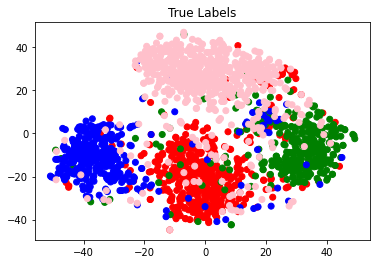


1) Using Spectral Clustering

Predicted Plot using Spectral Clustering


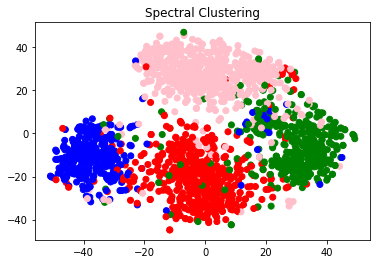

DER using Spectral Clustering = 0.10720980714806551
Summary: {'total': 357.94299999999987, 'false alarm': 0.0, 'correct': 319.56799999999987, 'confusion': 38.375, 'missed detection': 0.0, 'diarization error rate': 0.10720980714806551}
f1 Score: 0.8872343771423211
Confusion Matrix
[[409  25   2  11]
 [  8 291   5   4]
 [ 30  13 269   7]
 [ 40  33   7 475]]


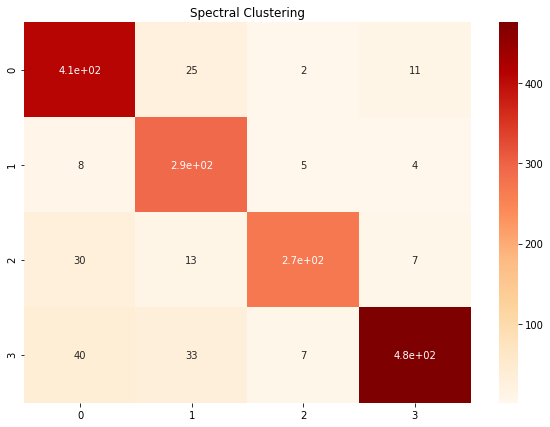


2) Using GANMM Clustering

Predicted Plot using GANMM Clustering


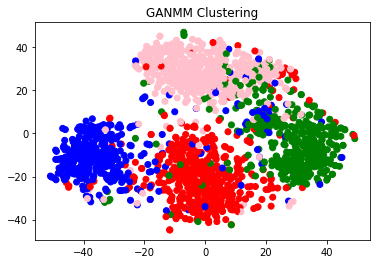

DER using GANMM Clustering = 0.07647865721637245
Summary: {'total': 357.94299999999987, 'false alarm': 0.0, 'correct': 330.56799999999987, 'confusion': 27.374999999999996, 'missed detection': 0.0, 'diarization error rate': 0.07647865721637245}
f1 Score: 0.8479811122108437
Confusion Matrix
[[393  22  22  10]
 [ 12 285   9   2]
 [ 23   8 285   3]
 [ 42  65  30 418]]


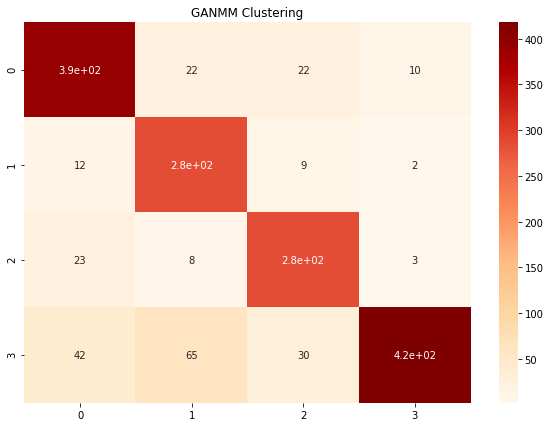

In [162]:
test_file = 'IS1000c'
timelines = predictions(test_file)

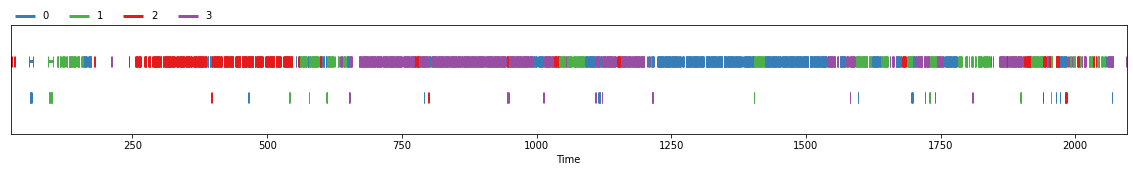

In [163]:
timelines[0]    # True referance timeline

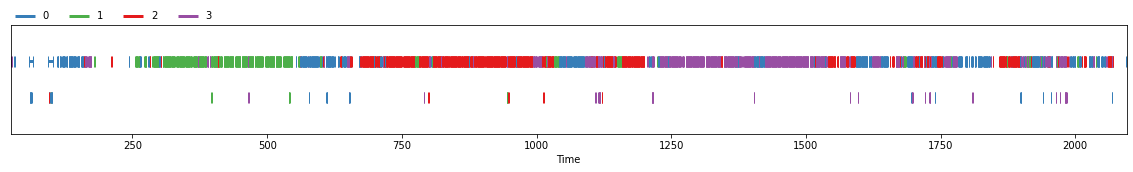

In [164]:
timelines[1]    # Predicted Timeline using Spectral Clustering Algorithm

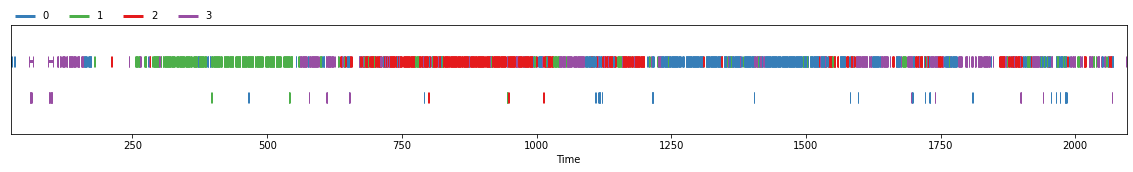

In [166]:
timelines[3]    # Predicted Timeline using GANMM Algorithm

## Comparing Spectral Clustering and GANMM on Imbalanced Data

processing files of:  custom_3
Number of embeddings:  450

2D embeddings plot for True Labels of test file


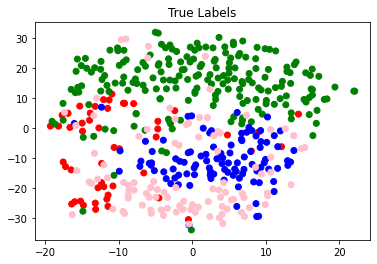


1) Using Spectral Clustering

Predicted Plot using Spectral Clustering


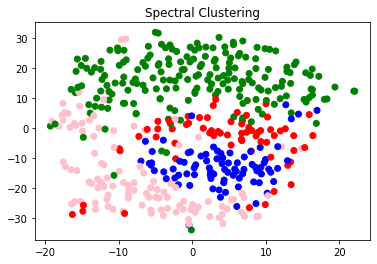

DER using Spectral Clustering = 0.29555555555555557
Summary: {'total': 450.0, 'false alarm': 0.0, 'correct': 317.0, 'confusion': 133.0, 'missed detection': 0.0, 'diarization error rate': 0.29555555555555557}
f1 Score: 0.7166930757739784
Confusion Matrix
[[  8  10   1  31]
 [ 11 178   3   8]
 [ 25   1  68   6]
 [ 21   6  10  63]]


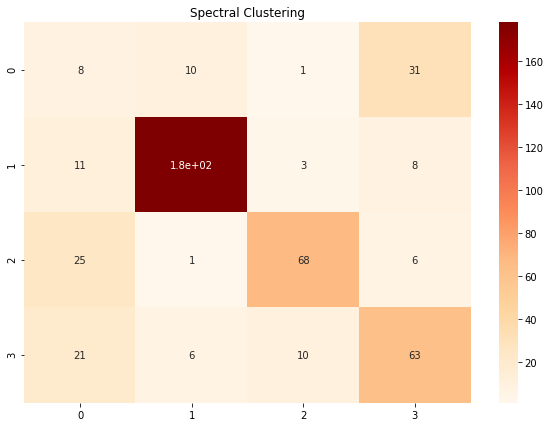


2) Using GANMM Clustering

Predicted Plot using GANMM Clustering


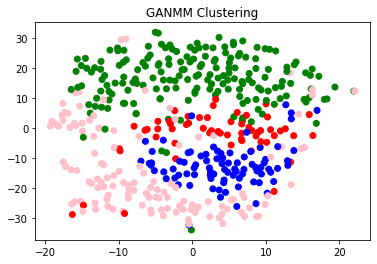

DER using GANMM Clustering = 0.2911111111111111
Summary: {'total': 450.0, 'false alarm': 0.0, 'correct': 319.0, 'confusion': 131.0, 'missed detection': 0.0, 'diarization error rate': 0.2911111111111111}
f1 Score: 0.7202609590393184
Confusion Matrix
[[  9   8   0  33]
 [ 13 168   4  15]
 [ 22   1  71   6]
 [ 14   5  10  71]]


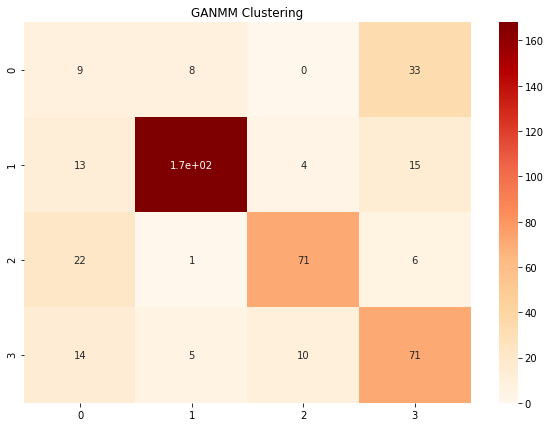

In [168]:
test_file = 'custom_3'
timelines = predictions(test_file)

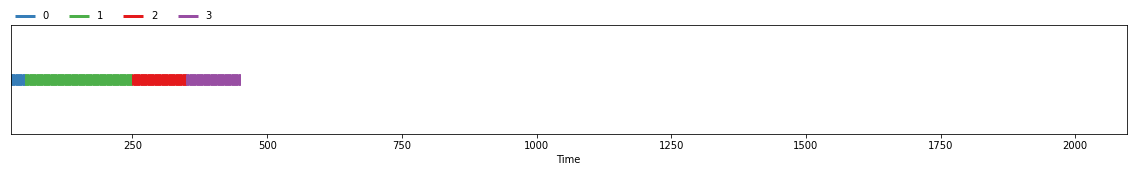

In [169]:
timelines[0]    # True referance timeline

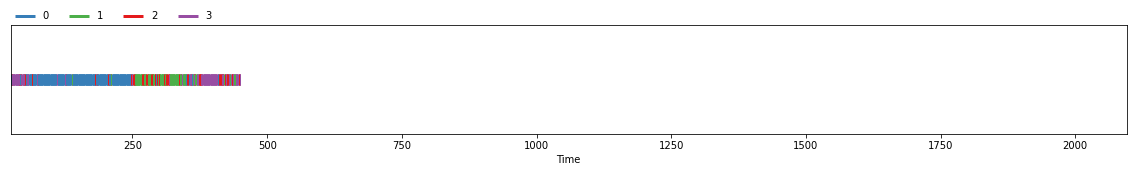

In [170]:
timelines[1]    # Predicted Timeline using Spectral Clustering Algorithm

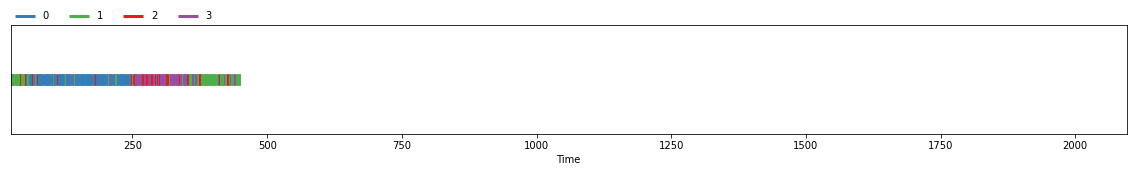

In [171]:
timelines[3]    # Predicted Timeline using GANMM Algorithm